In [1]:
import os
import logging
import sys
sys.path.append('../')

from rdkit import RDLogger
from args import get_GAN_config
from util_dir.utils_io import get_date_postfix

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Remove flooding logs.
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import math

import rdkit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.backends import cudnn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from pysmiles import read_smiles

import numpy as np


# TqdmWarning: IProgress not found. Please update jupyter and ipywidgets.
# pip install ipywidgets

### Set config

In [2]:
config = get_GAN_config()
%tb

No traceback available to show.


In [4]:
print(config)

Namespace(z_dim=8, g_conv_dim=[128, 256, 512], d_conv_dim=[[128, 64], 128, [128, 64]], lambda_cls=1, lambda_rec=10, lambda_gp=10.0, post_method='softmax', batch_size=32, num_epochs=150, g_lr=0.0001, d_lr=0.0001, dropout=0.0, n_critic=5, resume_epoch=None, test_epochs=100, num_workers=1, mode='train', mol_data_dir='data/qm9_5k.sparsedataset', saving_dir='../exp_results/GAN/', log_step=1, sample_step=1000, model_save_step=1, lr_update_step=1000, lambda_wgan=0.0)


In [5]:
config.saving_dir = os.path.join(config.saving_dir, get_date_postfix())
config.log_dir_path = os.path.join(config.saving_dir, 'log_dir')
config.model_dir_path = os.path.join(config.saving_dir, 'model_dir')
config.img_dir_path = os.path.join(config.saving_dir, 'img_dir')

In [6]:
# Create directories if not exist.
if not os.path.exists(config.log_dir_path):
    os.makedirs(config.log_dir_path)
if not os.path.exists(config.model_dir_path):
    os.makedirs(config.model_dir_path)
if not os.path.exists(config.img_dir_path):
    os.makedirs(config.img_dir_path)

In [7]:
log_p_name = os.path.join(config.log_dir_path, get_date_postfix() + '_logger.log')
logging.basicConfig(filename=log_p_name, level=logging.INFO)
logging.info(config)

In [8]:
config.mol_data_dir = '../data/qm9_5k.sparsedataset'

### Dataloader

In [9]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [10]:
data = SparseMolecularDataset()
data.load(config.mol_data_dir)

In [11]:
# Model configurations.
z_dim = config.z_dim
m_dim = data.atom_num_types
b_dim = data.bond_num_types
g_conv_dim = config.g_conv_dim
d_conv_dim = config.d_conv_dim
la = config.lambda_wgan
lambda_rec = config.lambda_rec
la_gp = config.lambda_gp
post_method = config.post_method
metric = 'validity,qed'
# Training configurations.
batch_size = config.batch_size
num_epochs = config.num_epochs
num_steps = (len(data) // batch_size)
g_lr = config.g_lr
d_lr = config.d_lr
dropout = config.dropout
if  la > 0:
    n_critic = config.n_critic
else:
    n_critic = 1
resume_epoch = config.resume_epoch
# Training or testing.
mode = config.mode

# Miscellaneous.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)
# Directories.
log_dir_path = config.log_dir_path
model_dir_path = config.model_dir_path
img_dir_path = config.img_dir_path

# Step size.
model_save_step = config.model_save_step

Device:  cuda


### Build model

#### Layers

In [12]:
class MultiDenseLayer(Module):
    # aux_unit = 8, linear_units = [128, 256, 512], activation = Tanh()
    def __init__(self, aux_unit, linear_units, activation=None, dropout_rate=0.):
        super(MultiDenseLayer, self).__init__()
        layers = []
        for c0, c1 in zip([aux_unit] + linear_units[:-1], linear_units):
            layers.append(nn.Linear(c0, c1))
            layers.append(nn.Dropout(dropout_rate))
            if activation is not None:
                layers.append(activation)
        self.linear_layer = nn.Sequential(*layers)

    def forward(self, inputs):
        h = self.linear_layer(inputs)
        return h

In [13]:
class MultiGraphConvolutionLayers(Module):
    # in_features: 5, units: [128, 64], activation: Tanh, edge_type_num: 4,
    # with_features: False, f_dim: 0, dropout_rate = 0
    def __init__(self, in_features, units, activation, edge_type_num, with_features=False, f=0, dropout_rate=0.):
        super(MultiGraphConvolutionLayers, self).__init__()
        self.conv_nets = nn.ModuleList()
        self.units = units
        in_units = []
        if with_features:
            for i in range(len(self.units)):
                in_units = list([x + in_features for x in self.units])
            for u0, u1 in zip([in_features+f] + in_units[:-1], self.units):
                self.conv_nets.append(GraphConvolutionLayer(u0, u1, activation, edge_type_num, dropout_rate))
        else:
            for i in range(len(self.units)):
                in_units = list([x + in_features for x in self.units])
            for u0, u1 in zip([in_features] + in_units[:-1], self.units):
                self.conv_nets.append(GraphConvolutionLayer(u0, u1, activation, edge_type_num, dropout_rate))

    def forward(self, n_tensor, adj_tensor, h_tensor=None):
        hidden_tensor = h_tensor
        for conv_idx in range(len(self.units)):
            hidden_tensor = self.conv_nets[conv_idx](n_tensor, adj_tensor, hidden_tensor)
        return hidden_tensor

In [14]:
class GraphConvolution(Module):
    # in_features: 5, graph_conv_units: [128, 64], edge_type_num: 4, with_features: False, f_dim: 0, dropout_rate: 0
    def __init__(self, in_features, graph_conv_units, edge_type_num, with_features=False, f_dim=0, dropout_rate=0.):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.graph_conv_units = graph_conv_units
        self.activation_f = torch.nn.Tanh()
        # in_features: 5, self.graph_conv_units: [128, 64], self.activation_f: Tanh, edge_type_num: 4,
        # with_features: False, f_dim: 0, dropout_rate = 0
        self.multi_graph_convolution_layers = \
            MultiGraphConvolutionLayers(in_features, self.graph_conv_units, self.activation_f, edge_type_num,
                                        with_features, f_dim, dropout_rate)

    def forward(self, n_tensor, adj_tensor, h_tensor=None):
        output = self.multi_graph_convolution_layers(n_tensor, adj_tensor, h_tensor)
        return output


In [15]:
class GraphConvolutionLayer(Module):
    # in_features = 5, u = graph_conv_units = 128, activation_f = Tanh, edge_type_num = 5                                    
    def __init__(self, in_features, u, activation, edge_type_num, dropout_rate=0.):
        super(GraphConvolutionLayer, self).__init__()
        self.edge_type_num = edge_type_num
        self.u = u
        self.adj_list = nn.ModuleList()
        # Edge type specific linear transformation.
        for _ in range(self.edge_type_num):
            self.adj_list.append(nn.Linear(in_features, u))
        # Self-connected linear transformation.
        self.linear_2 = nn.Linear(in_features, u)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, n_tensor, adj_tensor, h_tensor=None):
        # When Additional features are used.
        if h_tensor is not None:
            annotations = torch.cat((n_tensor, h_tensor), -1)
        else:
            annotations = n_tensor
        # output: [batch_size, edge_type_num, u]
        output = torch.stack([self.adj_list[i](annotations) for i in range(self.edge_type_num)], 1)
        # output: [batch_size, u]
        output = torch.matmul(adj_tensor, output)
        # out_sum: [batch_size, 1]
        out_sum = torch.sum(output, 1)
        out_linear_2 = self.linear_2(annotations)
        output = out_sum + out_linear_2
        output = self.activation(output) if self.activation is not None else output
        output = self.dropout(output)
        return output

In [16]:
class GraphAggregation(Module):
    # Readout layer.
    def __init__(self, in_features, aux_units, activation, with_features=False, f_dim=0,
                 dropout_rate=0.):
        super(GraphAggregation, self).__init__()
        self.with_features = with_features
        self.activation = activation
        if self.with_features:
            self.i = nn.Sequential(nn.Linear(in_features+f_dim, aux_units),
                                   nn.Sigmoid())
            j_layers = [nn.Linear(in_features+f_dim, aux_units)]
            if self.activation is not None:
                j_layers.append(self.activation)
            self.j = nn.Sequential(*j_layers)
        else:
            self.i = nn.Sequential(nn.Linear(in_features, aux_units),
                                   nn.Sigmoid())
            j_layers = [nn.Linear(in_features, aux_units)]
            if self.activation is not None:
                j_layers.append(self.activation)
            self.j = nn.Sequential(*j_layers)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, n_tensor, out_tensor, h_tensor=None):
        if h_tensor is not None:
            annotations = torch.cat((out_tensor, h_tensor, n_tensor), -1)
        else:
            annotations = torch.cat((out_tensor, n_tensor), -1)
        # The i here seems to be an attention.
        i = self.i(annotations)
        j = self.j(annotations)
        output = torch.sum(torch.mul(i, j), 1)
        if self.activation is not None:
            output = self.activation(output)
        output = self.dropout(output)

        return output

In [17]:
class Generator(nn.Module):
    """Generator network."""
    # conv_dims = [128, 256, 512], z_dim = 8, vertexes = 9, edges = 5, nodes = 5, dropout = 0.0
    def __init__(self, conv_dims, z_dim, vertexes, edges, nodes, dropout_rate):
        super(Generator, self).__init__()
        self.activation_f = torch.nn.Tanh()
        # z_dim = 8, conv_dims = [128, 256, 512], activation = Tanh()
        self.multi_dense_layer = MultiDenseLayer(z_dim, conv_dims, self.activation_f)
        self.vertexes = vertexes
        self.edges = edges
        self.nodes = nodes
        # edges_layer 512 -> edges * vertexes * vertexes = 5 * 9 * 9 = 405
        self.edges_layer = nn.Linear(conv_dims[-1], edges * vertexes * vertexes)
        # node_layer 512 -> vertexes * nodes = 9 * 5 = 45
        self.nodes_layer = nn.Linear(conv_dims[-1], vertexes * nodes)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # 8 -> 128 -> 256 -> 512
        output = self.multi_dense_layer(x)
        # 405 -> batch_size * 5 * 9 * 9
        edges_logits = self.edges_layer(output).view(-1, self.edges, self.vertexes, self.vertexes)
        # Change the order of the dimensions: batch_size * 5 * 9 * 9 -> batch_size * 5 * 9 * 9
        # Average the matrix and its transpose: (A + A^T) / 2
        edges_logits = (edges_logits + edges_logits.permute(0, 1, 3, 2)) / 2
        # batch_size * 5 * 9 * 9 -> batch_size * 9 * 9 * 5
        edges_logits = self.dropout(edges_logits.permute(0, 2, 3, 1))

        # 512 -> 45
        nodes_logits = self.nodes_layer(output)
        # 45 -> batch_size * 9 * 5
        nodes_logits = self.dropout(nodes_logits.view(-1, self.vertexes, self.nodes))

        return edges_logits, nodes_logits

In [119]:
b_dim

5

In [18]:
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    # conv_dim: [[128, 64], 128, [128, 64]], m_dim: 5, b_dim: 4
    def __init__(self, conv_dim, m_dim, b_dim, with_features=False, f_dim=0, dropout_rate=0.):
        super(Discriminator, self).__init__()
        self.activation_f = torch.nn.Tanh()
        # graph_conv_dim = [128, 64], aux_dim = 128, linear_dim = [128, 64]
        graph_conv_dim, aux_dim, linear_dim = conv_dim
        # discriminator
        # m_dim: 5, graph_conv_dim: [128, 64], b_dim: 4, with_features: False, f_dim: 0, dropout_rate: 0
        self.gcn_layer = GraphConvolution(m_dim, graph_conv_dim, b_dim, with_features, f_dim, dropout_rate)
        self.agg_layer = GraphAggregation(graph_conv_dim[-1] + m_dim, aux_dim, self.activation_f, with_features, f_dim,
                                          dropout_rate)
        self.multi_dense_layer = MultiDenseLayer(aux_dim, linear_dim, self.activation_f, dropout_rate=dropout_rate)

        self.output_layer = nn.Linear(linear_dim[-1], 1)

    # adj = 32 * 9 * 9 * 5, hidden = 32 * 9 * 128, node = 32 * 9 * 5
    def forward(self, adj, hidden, node, activation=None):
        adj = adj[:, :, :, 1:].permute(0, 3, 1, 2)
        h_1 = self.gcn_layer(node, adj, hidden)
        h = self.agg_layer(h_1, node, hidden)
        h = self.multi_dense_layer(h)

        output = self.output_layer(h)
        output = activation(output) if activation is not None else output

        return output, h

In [19]:
G = Generator(g_conv_dim,
          z_dim,
          data.vertexes,
          data.bond_num_types,
          data.atom_num_types,
          dropout
)

In [20]:
D = Discriminator(d_conv_dim, m_dim, b_dim - 1, dropout)
V = Discriminator(d_conv_dim, m_dim, b_dim - 1, dropout)

In [21]:
def print_network(model, name, log=None):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))
    if log is not None:
        log.info(model)
        log.info(name)
        log.info("The number of parameters: {}".format(num_params))

In [22]:
g_optimizer = torch.optim.RMSprop(G.parameters(), g_lr)
d_optimizer = torch.optim.RMSprop(D.parameters(), d_lr)
v_optimizer = torch.optim.RMSprop(V.parameters(), g_lr)
print_network(G, 'G', logging)
print_network(D, 'D', logging)
print_network(V, 'V', logging)

G.to(device)
D.to(device)
V.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layer): MultiDenseLayer(
    (linear_layer): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): Dropout(p=0.0, inplace=False)
      (5): Tanh()
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): Dropout(p=0.0, inplace=False)
      (8): Tanh()
    )
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 396610
Discriminator(
  (activation_f): Tanh()
  (gcn_layer): GraphConvolution(
    (activation_f): Tanh()
    (multi_graph_convolution_layers): MultiGraphConvolutionLayers(
      (conv_nets): ModuleList(
        (0): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_f

Discriminator(
  (activation_f): Tanh()
  (gcn_layer): GraphConvolution(
    (activation_f): Tanh()
    (multi_graph_convolution_layers): MultiGraphConvolutionLayers(
      (conv_nets): ModuleList(
        (0): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=5, out_features=128, bias=True)
            (1): Linear(in_features=5, out_features=128, bias=True)
            (2): Linear(in_features=5, out_features=128, bias=True)
            (3): Linear(in_features=5, out_features=128, bias=True)
          )
          (linear_2): Linear(in_features=5, out_features=128, bias=True)
          (activation): Tanh()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=133, out_features=64, bias=True)
            (1): Linear(in_features=133, out_features=64, bias=True)
            (2): Linear(in_features=133, out_features=64, bias=True)
      

In [120]:
print_network(G, 'G', logging)

Generator(
  (activation_f): Tanh()
  (multi_dense_layer): MultiDenseLayer(
    (linear_layer): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): Dropout(p=0.0, inplace=False)
      (5): Tanh()
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): Dropout(p=0.0, inplace=False)
      (8): Tanh()
    )
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 396610


In [121]:
print_network(D, 'D', logging)

Discriminator(
  (activation_f): Tanh()
  (gcn_layer): GraphConvolution(
    (activation_f): Tanh()
    (multi_graph_convolution_layers): MultiGraphConvolutionLayers(
      (conv_nets): ModuleList(
        (0): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=5, out_features=128, bias=True)
            (1): Linear(in_features=5, out_features=128, bias=True)
            (2): Linear(in_features=5, out_features=128, bias=True)
            (3): Linear(in_features=5, out_features=128, bias=True)
          )
          (linear_2): Linear(in_features=5, out_features=128, bias=True)
          (activation): Tanh()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=133, out_features=64, bias=True)
            (1): Linear(in_features=133, out_features=64, bias=True)
            (2): Linear(in_features=133, out_features=64, bias=True)
      

In [122]:
print_network(V, 'V', logging)

Discriminator(
  (activation_f): Tanh()
  (gcn_layer): GraphConvolution(
    (activation_f): Tanh()
    (multi_graph_convolution_layers): MultiGraphConvolutionLayers(
      (conv_nets): ModuleList(
        (0): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=5, out_features=128, bias=True)
            (1): Linear(in_features=5, out_features=128, bias=True)
            (2): Linear(in_features=5, out_features=128, bias=True)
            (3): Linear(in_features=5, out_features=128, bias=True)
          )
          (linear_2): Linear(in_features=5, out_features=128, bias=True)
          (activation): Tanh()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): GraphConvolutionLayer(
          (adj_list): ModuleList(
            (0): Linear(in_features=133, out_features=64, bias=True)
            (1): Linear(in_features=133, out_features=64, bias=True)
            (2): Linear(in_features=133, out_features=64, bias=True)
      

### Train


### Train single step

In [23]:
cur_la = la
epoch_i = 0
a_step = 0

In [24]:
from collections import defaultdict
losses = defaultdict(list)
scores = defaultdict(list)
the_step = 1

In [28]:
# data, smiles, data_S, data_A, data_X, data_D, data_F, data_Le, data_Lv
# a: Adjacent matrix,
# x: node 
mols, smiles, _, a, x, _, _, _, _ = data.next_train_batch(batch_size) # generator

#### Investigate single data

##### molecular graph

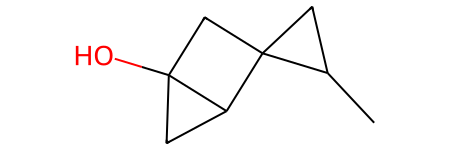

In [29]:
mols[1]

In [30]:
smiles[1]

'CC1CC12CC1(O)CC12'

##### molecular graph with detail

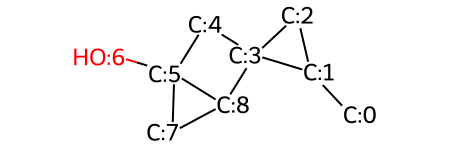

In [31]:
for i, atom in enumerate(mols[1].GetAtoms()):
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx()))
mols[1]

##### how to make adjacent matrix

In [32]:
max_length = None
max_length = max_length if max_length is not None else mols[1].GetNumAtoms()

In [33]:
[b.GetBeginAtomIdx() for b in mols[1].GetBonds()]

[0, 1, 2, 3, 4, 5, 5, 7, 3, 8, 8]

In [34]:
[b.GetEndAtomIdx() for b in mols[1].GetBonds()]

[1, 2, 3, 4, 5, 6, 7, 8, 1, 5, 3]

In [35]:
# get directed graph
begin, end = [b.GetBeginAtomIdx() for b in mols[1].GetBonds()], [b.GetEndAtomIdx() for b in mols[1].GetBonds()]

In [36]:
A = np.zeros(shape=(max_length, max_length), dtype=np.int32)

##### Get Bond Type
* 모든 bond type을 다가져와야 하나 여기서는 32개의 sample에 대한 bond type만 가지고 와서 bond_encoder_m이라는 index set을 만들고
* 실제 bond type을 저장

In [37]:
from rdkit import Chem
bond_labels = [Chem.rdchem.BondType.ZERO] + list(sorted(set(bond.GetBondType()
                                                            for mol in mols
                                                            for bond in mol.GetBonds())))
bond_encoder_m = {l: i for i, l in enumerate(bond_labels)}
bond_type = [bond_encoder_m[b.GetBondType()] for b in mols[1].GetBonds()]

In [38]:
bond_type

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [39]:
# Make adjacent matrix
# Position: connection, Value: bond type
A[begin, end] = bond_type
A[end, begin] = bond_type

In [40]:
A

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 1, 0]], dtype=int32)

In [41]:
bond_type

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [42]:
degree = np.sum(A[:mols[1].GetNumAtoms(), :mols[1].GetNumAtoms()], axis=-1)

In [43]:
degree

array([1, 3, 2, 4, 2, 4, 1, 2, 3])

##### How to make node tensor 

In [44]:
atom_labels = sorted(set([atom.GetAtomicNum() for mol in mols for atom in mol.GetAtoms()] + [0]))
atom_encoder_m = {l: i for i, l in enumerate(atom_labels)}

In [45]:
atom_encoder_m

{0: 0, 6: 1, 7: 2, 8: 3, 9: 4}

#### Preprocess

In [46]:
node = np.array([
        atom_encoder_m[atom.GetAtomicNum()] 
        for atom in mols[1].GetAtoms()
        ] + [0] * ( max_length - mols[1].GetNumAtoms() ), dtype=np.int32)

In [58]:
def label2onehot(labels, dim):
    """Convert label indices to one-hot vectors."""
    out = torch.zeros(list(labels.size()) + [dim]).to(device)
    out.scatter_(len(out.size()) - 1, labels.unsqueeze(-1), 1.)
    return out

def sample_z(batch_size):
    return np.random.normal(0, 1, size=(batch_size, z_dim))

In [59]:
z = sample_z(a.shape[0])

In [64]:
a.shape[0]

32

In [66]:
# 이미 GPU에 올라가 있으면 아래 코드 중 첫 두줄은 필요 없음
a = torch.from_numpy(a).to(device).long()  # Adjacency.
x = torch.from_numpy(x).to(device).long()  # Nodes.
a_tensor = label2onehot(a, b_dim)
x_tensor = label2onehot(x, m_dim)
z = torch.from_numpy(z).to(device).float()

In [67]:
cur_step = num_steps * epoch_i + a_step

#### Train discriminator

In [69]:
# a_tensor: Adjacent matrix
# x_tensor: node
logits_real, features_real = D(a_tensor, None, x_tensor)

In [71]:
x_tensor.shape

torch.Size([32, 9, 5])

In [72]:
edges_logits, nodes_logits = G(z)

In [76]:
edges_logits.shape

torch.Size([32, 9, 9, 5])

In [100]:
def postprocess(inputs, method, temperature=1.):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]

    def delistify(x):
        return x if len(x) > 1 else x[0]

    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))
                                    / temperature, hard=False).view(e_logits.size())
                   for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))
                                    / temperature, hard=True).view(e_logits.size())
                   for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits / temperature, -1)
                   for e_logits in listify(inputs)]

    return [delistify(e) for e in (softmax)]

In [101]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)

In [108]:
nodes_hat.shape

torch.Size([32, 9, 5])

In [109]:
edges_hat[1, :, :, 4].shape

torch.Size([9, 9])

In [110]:
logits_fake, features_fake = D(edges_hat, None, nodes_hat)

In [117]:
logits_fake[0]

torch.Size([1])

In [ ]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx ** 2, dim=1))
    return torch.mean((dydx_l2norm - 1) ** 2)

In [ ]:
# Compute losses for gradient penalty.
eps = torch.rand(logits_real.size(0), 1, 1, 1).to(device)
x_int0 = (eps * a_tensor + (1. - eps) * edges_hat).requires_grad_(True)
x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
grad0, grad1 = D(x_int0, None, x_int1)
grad_penalty = gradient_penalty(grad0, x_int0) + gradient_penalty(grad1, x_int1)

In [ ]:
d_loss_real = torch.mean(logits_real)
d_loss_fake = torch.mean(logits_fake)
loss_D = - d_loss_real + d_loss_fake + la_gp * grad_penalty

In [ ]:
losses['l_D/R'].append(d_loss_real.item())
losses['l_D/F'].append(d_loss_fake.item())
losses['l_D'].append(loss_D.item())

In [ ]:
losses

defaultdict(list,
            {'l_D/R': [0.30454879999160767],
             'l_D/F': [0.0014736459124833345],
             'l_D': [7.486253261566162]})

In [ ]:
def reset_grad():
    """Reset the gradient buffers."""
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    v_optimizer.zero_grad()

In [ ]:
reset_grad()
loss_D.backward()

In [ ]:
d_optimizer.step()

In [ ]:
# d_optimizer.state_dict()['state'][0]['square_avg']

#### Train Generator

In [ ]:
metric

'validity,qed'

In [ ]:
def reward(mols):
    rr = 1.
    for m in ('logp,sas,qed,unique' if metric == 'all' else metric).split(','):
        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        elif m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        elif m == 'dc':
            rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))
    return rr.reshape(-1, 1)

In [ ]:
def get_reward(n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
            for e_, n_ in zip(edges_hard, nodes_hard)]
    _reward = torch.from_numpy(reward(mols)).to(device)
    return _reward

In [ ]:
# Z-to-target
edges_logits, nodes_logits = G(z)
# Postprocess with Gumbel softmax
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)
logits_fake, features_fake = D(edges_hat, None, nodes_hat)

In [ ]:
# Value losses
value_logit_real, _ = V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake, _ = V(edges_hat, None, nodes_hat, torch.sigmoid)

In [ ]:
from utils import MolecularMetrics

In [ ]:
# Feature mapping losses. Not used anywhere in the PyTorch version.
# I include it here for the consistency with the TF code.
f_loss = (torch.mean(features_real, 0) - torch.mean(features_fake, 0)) ** 2

# Real Reward
reward_r = torch.from_numpy(reward(mols)).to(device)
# Fake Reward
reward_f = get_reward(nodes_hat, edges_hat, post_method)


In [ ]:
# Losses Update
loss_G = -logits_fake
# Original TF loss_V. Here we use absolute values instead of the squared one.
# loss_V = (value_logit_real - reward_r) ** 2 + (value_logit_fake - reward_f) ** 2
loss_V = torch.abs(value_logit_real - reward_r) + torch.abs(value_logit_fake - reward_f)
loss_RL = -value_logit_fake

In [ ]:
loss_RL.shape

torch.Size([32, 1])

In [ ]:

loss_G = torch.mean(loss_G)
loss_V = torch.mean(loss_V)
loss_RL = torch.mean(loss_RL)
losses['l_G'].append(loss_G.item())
losses['l_RL'].append(loss_RL.item())
losses['l_V'].append(loss_V.item())
alpha = torch.abs(loss_G.detach() / loss_RL.detach()).detach()
train_step_G = cur_la * loss_G + (1 - cur_la) * alpha * loss_RL

In [ ]:
torch.autograd.set_detect_anomaly(True) 

alpha = torch.abs(loss_G.detach() / loss_RL.detach()).detach()
train_step_G = cur_la * loss_G + (1 - cur_la) * alpha * loss_RL
train_step_V = loss_V
reset_grad()
# Optimise generator.
if cur_step % n_critic == 0:
    train_step_G.backward(retain_graph=True)
    g_optimizer.step()
# Optimise value network.
if cur_step % n_critic == 0:
    train_step_V.backward() ## 여기에서 에러가 난다.
    v_optimizer.step()

/home/kyle/.pyenv/versions/3.9.2/envs/molgan/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in AddmmBackward0. No forward pass information available. Enable detect anomaly during forward pass for more information. (Triggered internally at ../torch/csrc/autograd/python_anomaly_mode.cpp:92.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [512, 45]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
            # =================================================================================== #
            #                               3. Train the generator                                #
            # =================================================================================== #

            # Z-to-target
            edges_logits, nodes_logits = self.G(z)
            # Postprocess with Gumbel softmax
            (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
            logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)

            # Value losses
            value_logit_real, _ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
            value_logit_fake, _ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)

            # Feature mapping losses. Not used anywhere in the PyTorch version.
            # I include it here for the consistency with the TF code.
            f_loss = (torch.mean(features_real, 0) - torch.mean(features_fake, 0)) ** 2

            # Real Reward
            reward_r = torch.from_numpy(self.reward(mols)).to(self.device)
            # Fake Reward
            reward_f = self.get_reward(nodes_hat, edges_hat, self.post_method)

            # Losses Update
            loss_G = -logits_fake
            # Original TF loss_V. Here we use absolute values instead of the squared one.
            # loss_V = (value_logit_real - reward_r) ** 2 + (value_logit_fake - reward_f) ** 2
            loss_V = torch.abs(value_logit_real - reward_r) + torch.abs(value_logit_fake - reward_f)
            loss_RL = -value_logit_fake

            loss_G = torch.mean(loss_G)
            loss_V = torch.mean(loss_V)
            loss_RL = torch.mean(loss_RL)
            losses['l_G'].append(loss_G.item())
            losses['l_RL'].append(loss_RL.item())
            losses['l_V'].append(loss_V.item())

            alpha = torch.abs(loss_G.detach() / loss_RL.detach()).detach()
            train_step_G = cur_la * loss_G + (1 - cur_la) * alpha * loss_RL

            train_step_V = loss_V

            if train_val_test == 'train':
                self.reset_grad()

                # Optimise generator.
                if cur_step % self.n_critic == 0:
                    train_step_G.backward(retain_graph=True)
                    self.g_optimizer.step()

                # Optimise value network.
                if cur_step % self.n_critic == 0:
                    train_step_V.backward()
                    self.v_optimizer.step()

In [ ]:
start_epoch = 0
for i in range(start_epoch, num_epochs):
    self.train_or_valid(epoch_i=i, train_val_test='train')
    self.train_or_valid(epoch_i=i, train_val_test='val')